### Planted neural network

In [1]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.style.use("rotskoff")

In [2]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
class CloneNet(nn.Module):
    def __init__(self, n_dim, n_hid, n_out, alpha=0.01, dtype=torch.float):
        super(CloneNet, self).__init__()
        self.lin1 = nn.Linear(n_dim, n_hid, bias=False)
        self.lin2 = nn.Linear(n_hid, n_out, bias=False)
        self.n_dim = n_dim
        self.n_hid = n_hid
        self.n_out = n_out
        self.alpha = alpha
        self.dtype = dtype

    def forward(self, x):
        h_out = F.relu(self.lin1(x.view(-1, self.n_dim)))
        return self.lin2(h_out)

    def get_rates(self):
        acU = self.alpha * self.lin2.weight * self.lin2.weight.grad
        return acU.flatten()

    def birth_death(self):
        rates = self.get_rates()
        
        np = rates.shape[0] # number of particles
        # kill particles
        kill_mask = (rates < 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < torch.abs(rates))
        kill_vec = torch.tensor(kill_mask.unsqueeze(dim=1), dtype=self.dtype)
        n_kill = torch.sum(kill_mask)
        if n_kill > 0:
            # keep the survivors
            self.lin1.weight.data = (1 - kill_vec) * self.lin1.weight.data
            # resample the rows of lin1 where acU >= 0
            survivor_inds = torch.arange(0, np)[1 - kill_mask]
            # random survivor indices
            clone_inds = survivor_inds[torch.randint(survivor_inds.shape[0], (np,)).long()]
            # replace killed particles with random survivors
            self.lin1.weight.data += kill_vec * self.lin1.weight.data[clone_inds, :]
            # replace the corresponding weights or "charges"
            self.lin2.weight.data = self.lin2.weight.data * (1 - kill_vec.t()) + \
                kill_vec.t() * self.lin2.weight.data[:, clone_inds]
            #print("Killed {:d} particles".format(n_kill))
        
        clone_mask = (rates > 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < torch.abs(rates))
        clone_vec = torch.tensor(clone_mask.unsqueeze(dim=1), dtype=self.dtype)
        n_clone = torch.sum(clone_mask)
        if n_clone > 0:
            # get the indices of the particles to clone
            clones = torch.arange(0, np)[clone_mask]
            # select random indices from the non-cloned particles
            non_clones = torch.arange(0, np)[1-clone_mask]
            replace_inds = non_clones[torch.randint(np-n_clone, (n_clone,)).long()]
            # replace the particles in replace inds with the clones
            self.lin1.weight.data[replace_inds, :] = self.lin1.weight.data[clones, :]
            self.lin2.weight.data[:, replace_inds] = self.lin2.weight.data[:, clones]
            #print("Cloned {:d} particles".format(n_clone))
                   

    def birth_death_with_prior(self):
        rates = self.get_rates()
        kill_mask = (rates > 0.) * \
            (torch.rand(rates.shape, dtype=self.dtype) < rates)

        n_kill = torch.sum(kill_mask)
        if n_kill > 0:
            kill_vec = torch.tensor(
                kill_mask.unsqueeze(dim=1), dtype=self.dtype)

            # resample the rows of lin1 where acU > 0
            self.lin1.weight.data = (1 - kill_vec) * self.lin1.weight.data + kill_vec * \
                self.rho_y(self.lin1.weight.shape)
            self.lin2.weight.data = self.lin2.weight.data * (1 - kill_vec.t())

            if n_kill > 0:
                print("Killed {:d} particles".format(n_kill))

    def rho_y(self, shape):
        return torch.randn(shape, dtype=self.dtype) / n_hid

In [4]:
n_dim = 50
n_hid = 10
n_out = 1
teacher_net = CloneNet(n_dim, n_hid, n_out)
torch.nn.init.normal_(teacher_net.lin1.weight)
norms = torch.norm(teacher_net.lin1.weight.data, dim=1) * torch.abs(teacher_net.lin2.weight.data)
teacher_net.lin1.weight.data = (teacher_net.lin1.weight.data.t() / norms).t()

<IPython.core.display.Javascript object>


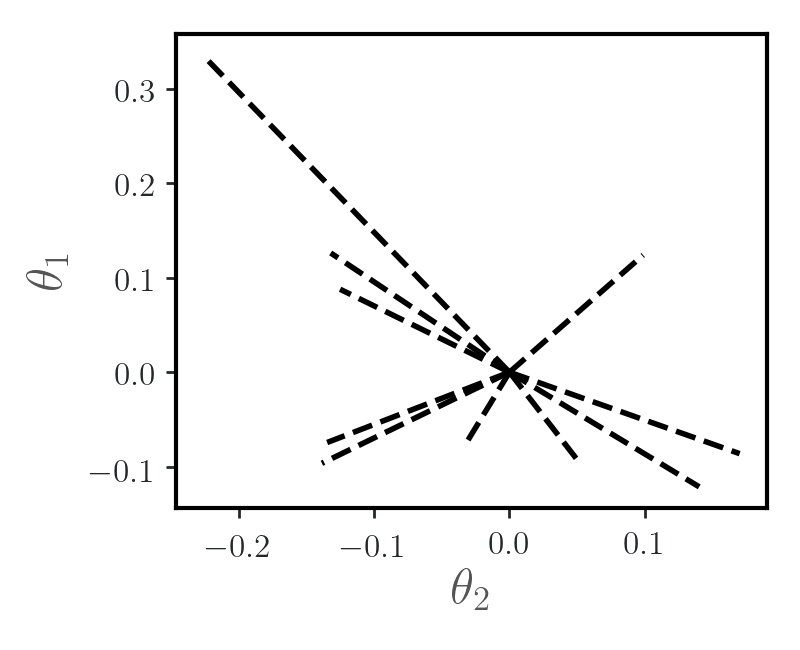

In [5]:
vs = (teacher_net.lin1.weight.data.t() * torch.abs(teacher_net.lin2.weight.data)).t()
vs = vs.numpy()
fig, ax = plt.subplots()

xs = np.linspace(0,1,100)
ax.set_ylabel(r"$\theta_1$", fontsize=18)
ax.set_xlabel(r"$\theta_2$", fontsize=18)
for i in range(len(vs)):
    ax.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")

In [6]:
n = 200
student_net = CloneNet(n_dim, n, n_out)
torch.nn.init.normal_(student_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[ 0.0289, -0.1773,  0.0626,  ..., -0.0421, -0.0027, -0.1183],
        [ 0.0740,  0.0865,  0.1056,  ...,  0.0413, -0.0895, -0.0079],
        [-0.0345, -0.0809, -0.0178,  ..., -0.0590,  0.0614,  0.0647],
        ...,
        [-0.0437,  0.0313,  0.0649,  ...,  0.0116,  0.0805,  0.0656],
        [ 0.0625,  0.1106, -0.1303,  ..., -0.0894,  0.0170,  0.0614],
        [-0.0206, -0.0504, -0.0559,  ...,  0.0097, -0.0003,  0.0046]],
       requires_grad=True)

In [7]:
# set the shared training parameters
learning_rate = 2e-2
n_steps = 100000
n_batch = 50
stride = 50
criterion = torch.nn.MSELoss()

In [8]:
optimizer = optim.SGD(student_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(student_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
student_traj = torch.zeros(traj_shape)
#for epoch in range(100):  # loop over the dataset multiple times
loss_data = np.zeros(n_steps)

#gaussian_data = torch.randn(n_batch, n_dim, dtype=torch.float)
#inputs =  gaussian_data /  torch.norm(gaussian_data, dim=0)

for i in range(n_steps):

    # zero the parameter gradient
    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch, n_dim, dtype=torch.float)
    inputs =  gaussian_data /  torch.norm(gaussian_data, dim=0)


    student_outputs = student_net(inputs)
    teacher_outputs = teacher_net(inputs)

    loss = criterion(student_outputs, teacher_outputs)
    loss.backward()
    optimizer.step()
    loss_data[i] = loss.data

    if (i%stride==0):
        thetai = torch.abs(student_net.lin2.weight.data.t()) * student_net.lin1.weight.data
        student_traj[i//stride] = thetai

print('Finished Training')

Finished Training


<IPython.core.display.Javascript object>


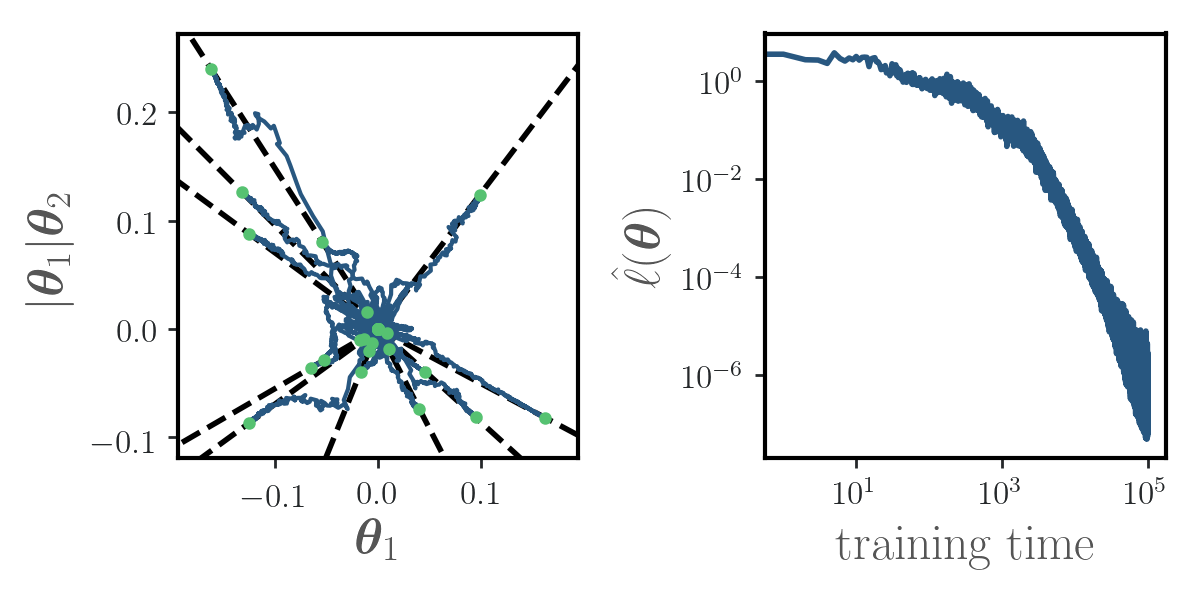

In [9]:
vs = (teacher_net.lin1.weight.data.t() * torch.abs(teacher_net.lin2.weight.data)).t()
vs = vs.numpy()
fig1, [ax1,ax2] = plt.subplots(1,2,figsize=(6,3))
#ax.set_xlim(-0.1,0.1)
#ax.set_ylim(-0.1,0.1)
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[:,i,0].numpy(), student_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[-1,i,0].numpy(), student_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])
    

xmin = torch.min(student_traj[:,:,0]).numpy()
ymin = torch.min(student_traj[:,:,1]).numpy()    
xmax = torch.max(student_traj[:,:,0]).numpy()
ymax = torch.max(student_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax + 0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
with torch.no_grad():
    ax2.loglog(loss_data)
    ax2.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
    ax2.set_xlabel(r"$\textrm{training time}$")
    
fig1.savefig("gd_traj.pdf")

In [10]:
clone_net = CloneNet(n_dim, n, n_out, alpha=0.001)
torch.nn.init.normal_(clone_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[-0.0234, -0.0009,  0.0313,  ...,  0.1001,  0.0055, -0.0568],
        [-0.0703,  0.0969, -0.0044,  ...,  0.0298, -0.0504,  0.0427],
        [-0.1130, -0.0073,  0.0373,  ...,  0.0428, -0.0410,  0.1050],
        ...,
        [ 0.0613,  0.1085,  0.0204,  ..., -0.1193,  0.0566,  0.0241],
        [ 0.0768,  0.0428, -0.0412,  ..., -0.1091,  0.1225,  0.0173],
        [ 0.0479, -0.0493, -0.0488,  ...,  0.0537,  0.0040, -0.0062]],
       requires_grad=True)

In [11]:
#criterion = torch.nn.MSELoss()
optimizer = optim.SGD(clone_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(clone_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
clone_traj = torch.zeros(traj_shape)
clone_loss_data = np.zeros(n_steps)

for i in range(n_steps):

    # zero the parameter gradients

    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch,n_dim,dtype=torch.float)
    inputs =  gaussian_data /  torch.norm(gaussian_data, dim=0)

    clone_outs = clone_net(inputs)
    teacher_outs = teacher_net(inputs)

    loss = criterion(clone_outs, teacher_outs)
    loss.backward()
    optimizer.step()
    clone_loss_data[i] = loss.data
    
    with torch.no_grad():
        #if i<(n_steps - n_steps//5):
        clone_net.birth_death()

        if (i%stride==0):
            thetai = torch.abs(clone_net.lin2.weight.data.t()) * clone_net.lin1.weight.data
            clone_traj[i//stride] = thetai

print('Finished Training')

Finished Training


<IPython.core.display.Javascript object>


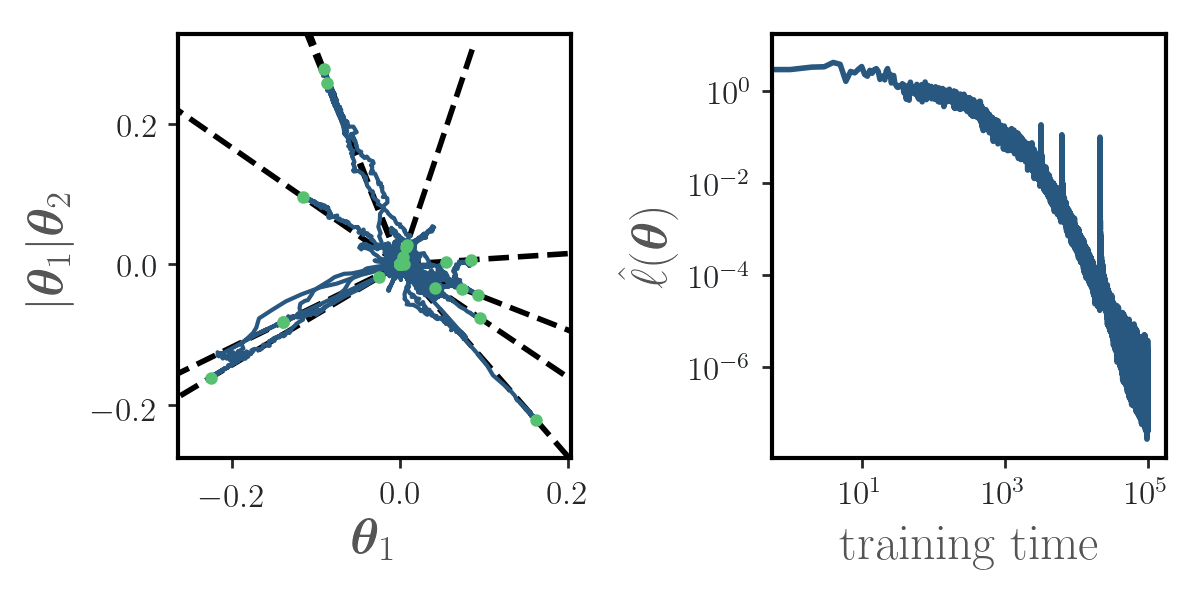

In [12]:
fig2, [ax1,ax2] = plt.subplots(1,2,figsize=(6,3))
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(clone_traj[:,i,0].numpy(), clone_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(clone_traj[-1,i,0].numpy(), clone_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])

    
xmin = torch.min(clone_traj[:,:,0]).numpy()
ymin = torch.min(clone_traj[:,:,1]).numpy()    
xmax = torch.max(clone_traj[:,:,0]).numpy()
ymax = torch.max(clone_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax+0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
with torch.no_grad():
    ax2.loglog(clone_loss_data)
    ax2.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
    ax2.set_xlabel(r"$\textrm{training time}$")

fig2.savefig("bd_traj.pdf")

In [13]:
prior_net = CloneNet(n_dim, n, n_out, alpha=0.001)
torch.nn.init.normal_(prior_net.lin1.weight, std=1./np.sqrt(n))

Parameter containing:
tensor([[-0.0108,  0.0324,  0.0693,  ...,  0.0991,  0.0145,  0.1427],
        [ 0.0416,  0.0001, -0.0167,  ..., -0.0112, -0.0149,  0.0849],
        [-0.0162, -0.1510, -0.0031,  ..., -0.1336, -0.1506, -0.0584],
        ...,
        [-0.1151, -0.0858,  0.0820,  ...,  0.0342,  0.0968, -0.0490],
        [ 0.0128, -0.0664,  0.0086,  ..., -0.0232,  0.0606, -0.0367],
        [-0.1028,  0.0663, -0.0007,  ..., -0.0746,  0.0477,  0.0159]],
       requires_grad=True)

In [14]:
#criterion = torch.nn.MSELoss()
optimizer = optim.SGD(prior_net.parameters(), lr=learning_rate)

traj_shape = list((n_steps//stride,*tuple(prior_net.lin1.weight.shape)))
traj_shape = tuple(traj_shape)
prior_traj = torch.zeros(traj_shape)
prior_loss_data = np.zeros(n_steps)

for i in range(n_steps):

    # zero the parameter gradients

    optimizer.zero_grad()
    gaussian_data = torch.randn(n_batch,n_dim,dtype=torch.float)
    inputs =  gaussian_data /  torch.norm(gaussian_data, dim=0)

    prior_outs = prior_net(inputs)
    teacher_outs = teacher_net(inputs)

    loss = criterion(prior_outs, teacher_outs)
    loss.backward()
    optimizer.step()
    prior_loss_data[i] = loss.data
    
    with torch.no_grad():
        #if i<(n_steps - n_steps//5):
        prior_net.birth_death_with_prior()

        if (i%stride==0):
            thetai = torch.abs(prior_net.lin2.weight.data.t()) * prior_net.lin1.weight.data
            prior_traj[i//stride] = thetai

print('Finished Training')

Killed 1 particles
Killed 1 particles
Killed 1 particles
Finished Training


<IPython.core.display.Javascript object>


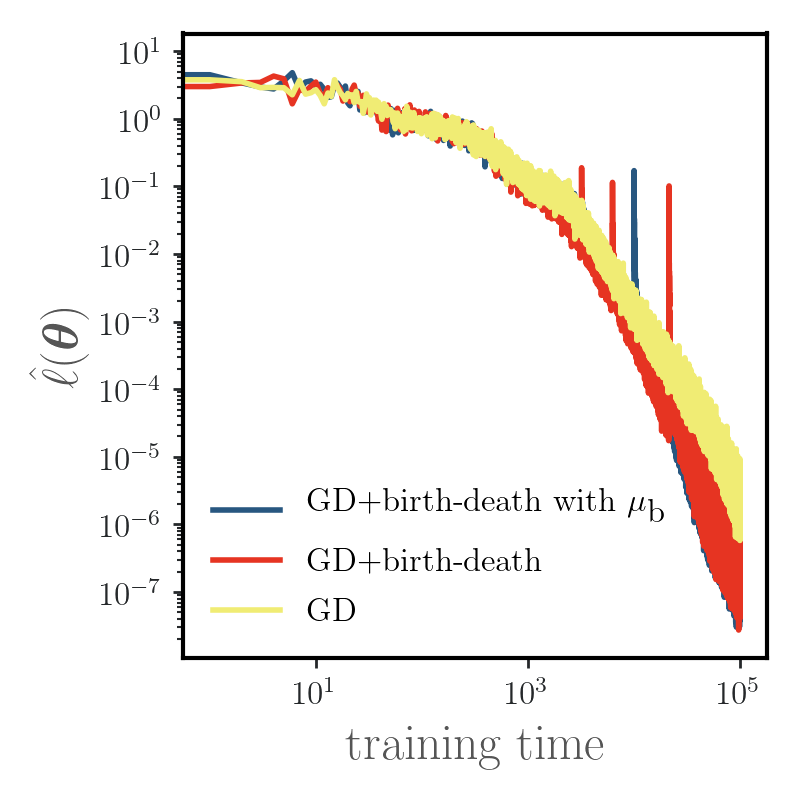

In [15]:
fig3, ax = plt.subplots(figsize=(4,4))
ax.loglog(prior_loss_data, label=r"$\textrm{GD+birth-death with }\mu_{\textrm{b}}$")
ax.loglog(clone_loss_data, label=r"$\textrm{GD+birth-death}$")
ax.loglog(loss_data, label=r"$\textrm{GD}$")
ax.set_ylabel(r"$\hat{\ell}(\boldsymbol{\theta})$")
ax.set_xlabel(r"$\textrm{training time}$")
ax.legend(fontsize=12)
fig3.savefig("planted_nn_loss_with_prior.pdf")

<IPython.core.display.Javascript object>


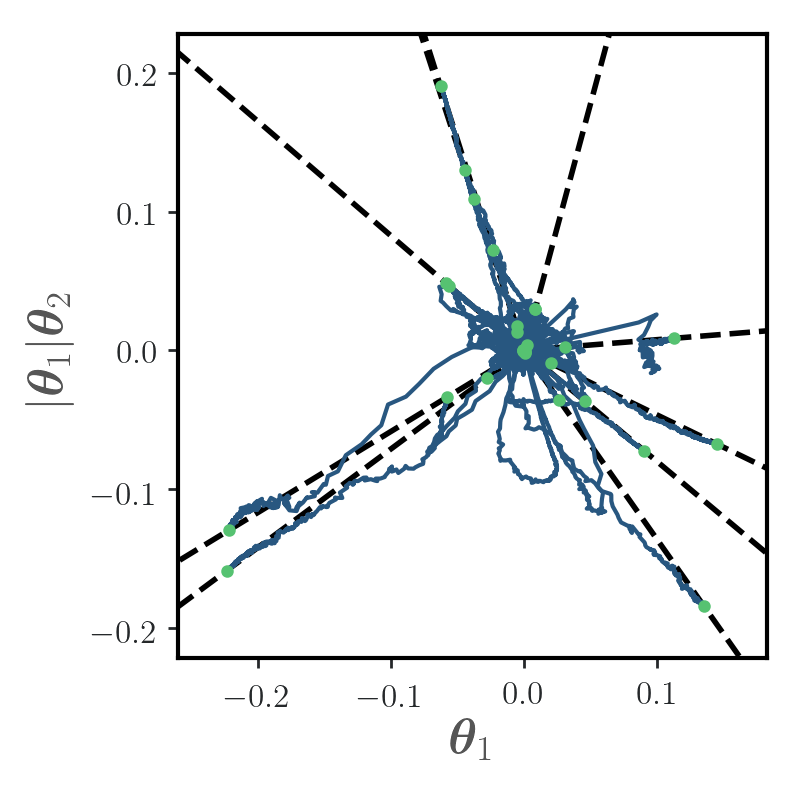

In [18]:
fig1, ax1 = plt.subplots(figsize=(4,4))
#ax.set_xlim(-0.1,0.1)
#ax.set_ylim(-0.1,0.1)
xs = np.linspace(0,5,100)
ax1.set_ylabel(r"$|\boldsymbol{\theta}_1|\boldsymbol{\theta}_2$", fontsize=18)
ax1.set_xlabel(r"$\boldsymbol{\theta}_1$", fontsize=18)


for i in range(len(vs)):
    ax1.plot(xs*vs[i,0], xs*vs[i,1], "--", color="k")
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[:,i,0].numpy(), student_traj[:,i,1].numpy(), color=colors[0], lw=1.5)
    
for i in range(student_traj.shape[1]):
    ax1.plot(student_traj[-1,i,0].numpy(), student_traj[-1,i,1].numpy(), "o", markersize=3.5, color=colors[3])
    

xmin = torch.min(student_traj[:,:,0]).numpy()
ymin = torch.min(student_traj[:,:,1]).numpy()    
xmax = torch.max(student_traj[:,:,0]).numpy()
ymax = torch.max(student_traj[:,:,1]).numpy()
dx = xmax-xmin
dy = ymax-ymin
ax1.set_xlim(xmin-0.1*dx,xmax + 0.1*dx)
ax1.set_ylim(ymin-0.1*dy,ymax+0.1*dy)
    
fig1.savefig("nn_gd_projection.pdf")